<h3 style="color:#6B6161
;font-size:160%;font-weight:italic;font-family:monaco;text-align:center;">Football Match Prediction</h3>

<p style="color:#6B6161
;font-size:90%;font-weight:italic;font-family:monaco;text-align:center;">Author: Orkhan Baghirli</p>

[![dataset|kernel](https://the18.com/sites/default/files/styles/feature_image_with_focal/public/Pele-Best-Goals-Career.jpg?itok=yW1-g7w3)]( http://jupyter.org/index.html)

In [1]:
# -------------------
# Project Description
# -------------------
# The objective of this project is to predict the probabilities of 2 facing teams in a football match winning,
# tieing, or losing. For this purpose, the expert knowledge dataset (outrights) with the odds for each team winning 
# the leauge before the season started, and the statistics of the previously played matches in the season (fixtures)
# have been used.

# ------------------------
# Approaching the problem:
# ------------------------
# Based of the results of the matches, generate the labels as win, tie, lose.
# Generate features that support the outcome
# Solve the problem as a supervised classification problem

# ------
# Stages
# ------
# 1) Data cleaning
# 2) Feature engineering
# 3) Scaling
# 4) PCA
# 5) Model building (6 different models)
# 6) Training/Tuning/CrossValidating
# 7) Predicting the test set
# 8) Model Comparison based on accuracy score
# 9) Choosing the best model
# 10) Predicting the probabilities for the unknown/unseen matches

# -----------------
# Data partitioning
# -----------------

#  <------------------0.75--------------><-----0.25-----><---#10-->
# |-------------------------|-----------|---------------|---------|
#         Train               CV(k=5)       Test          Predict

# ------------------
# Features Extracted
# ------------------

# 1) total_home_goals
#      number of goals home team scored as a home team

# 2) total_away_goals
#      number of goals away team scored as an away team

# 3) total_goal_difference (There will a section discussing the effect of such features)
#      total_home_goals - total_away_goals

# 4) home_odds
#      odds assigned to a home team

# 5) away_odds
#      odds assigned to an away team

# 6) odd_difference
#      home_odds - away_odds

# 7) same_event_home_goals
#      in the case of several A-B matches, cumulative goal count by team A (order of teams do matter)

# 8) same_event_away_goals
#      in the case of several A-B matches, cumulative goal count by team B (order of teams do matter)

# 9) same_event_goal_difference
#      same_event_home_goals - same_event_away_goals

# 10) home_experience
#       total number of games home team has played in the league

# 11) away_experience
#       total number of games away team has played in the league

# 12) experience_difference
#       home_experience - away_experience

# 13) similar_event_home_goals
#       in the case of several A-B or B-A, total number of goals home team (A) scored (order of teams do not matter)

# 14) similar_event_away_goals
#       in the case of several A-B or B-A, total number of goals away team (B) scored (order of teams do not matter)

# 15) similar_event_goal_difference
#       similar_event_home_goals - similar_event_away_goals

# ------
# Models
# ------

# 1) LogisticRegression
# 2) MLPClassifier (winner)
# 3) RandomForestClassifier
# 4) KNeighborsClassifier
# 5) GaussianNB
# 6) SVC

In [2]:
# install packages

# !pip install numpy==1.14.3
# !pip install scipy==1.1.0
# !pip install pandas==0.23.0
# !pip install scikit-learn==0.20.0
# !pip install matplotlib==2.2.3
# !pip install seaborn==0.9.0

In [3]:
import os
import sys
import time
import itertools

import sqlite3
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [4]:
# Environment setup
stdout = sys.stdout
reload(sys)
sys.setdefaultencoding("utf-8")
sys.stdout = stdout

# Path to fixtures and outrights data, a directory named 'data'
PATH_TO_INPUT = "/Users/orkhan.baghirli/Desktop/data"

# Switch between 'colombia' or 'sweden' just by changing the line below
LEAGUE = "sweden"
FIXTURES = 'fixtures_{0}'.format(LEAGUE)
OUTRIGHTS = 'outrights_{0}'.format(LEAGUE)
DATE_THRESHOLD = "2018-11-09"

Functions

In [5]:
# Functions used throughout the code

def load_data():
    """ Reads the csv files and return them as pandas dataframes
    
    Returns
    -------
    fixtures_raw: df
        Fixtures dataset
    
    outrights_raw: df
        Outrights dataset
    """
    file_id = "1000449742" if LEAGUE == "colombia" else "1000094745"
    fixtures_location = os.path.join(PATH_TO_INPUT, '{0}_{1}.csv'.format(FIXTURES, file_id))
    outrights_location = os.path.join(PATH_TO_INPUT, '{0}_{1}.csv'.format(OUTRIGHTS, file_id))
    fixtures_raw = pd.read_csv(fixtures_location)
    outrights_raw = pd.read_csv(outrights_location)
    return fixtures_raw, outrights_raw


def to_utf(df, columns):
    """ Convert the columns of a given df to utf-8
    
    Parameters
    -----------
    df: df
        Dataframe which the columns need to be converted
    
    columns: list
        Column names need to be converted
    
    Returns
    -------
    df: df
        Modified dataframe
    """
    for column in columns:
        df[column] = df[column].str.encode("utf-8")
    return df


def get_home_team(event_name):
    """ Splits the event name and get the home team name
    
    Parameters
    ----------
    event_name: str
        event_name field of the fixtures set
    
    Returns
    -------
    home_team: Seq
        extracted part from the event name
    """
    return event_name.split(" - ")[0].strip()


def get_away_team(event_name):
    """Splits the event name and get the away team name"""
    return event_name.split(" - ")[1].strip()


def get_home_goals(result):
    """Extracts the home goals from the results field"""
    return float(result.split(":")[0].strip())


def get_away_goals(result):
    """Extracts the away goals from the results field"""
    return float(result.split(":")[1].strip())


def generate_label(row):
    """ Labels the matches as win, lose, or tie
    
    Parameters
    ----------
    row: Row
        row of the dataframe this func is applied
    
    Returns
    -------
    label: Seq
        win, tie, or lose
    """
    home_goals = row['home_goals']
    away_goals = row['away_goals']

    if home_goals > away_goals:
        return "win"
    elif home_goals < away_goals:
        return "lose"
    else:
        return "tie"    

def calculate_A_and_B_no_order_total_goals(row):
    """ Calculates the similar_event_home_goals (feature# 13) 
        and similar_event_away_goals (feature# 14)
        
    Parameters
    ----------
    row: Row
        row of a dataframe this func is applied
    
    Returns
    -------
        [A_goals, B_goals]: list of float, A_B field (Seq)
            A_goals: feature #13
            B_goals: feature #14
    """
    home_team = row['home_team']
    away_team = row['away_team']
    
    db_query_1 = \
    """
    SELECT
        feat.home_team,
        feat.away_team,
        SUM(feat.home_goals) AS home_goals,
        SUM(feat.away_goals) AS away_goals
    FROM features feat
    WHERE feat.home_team='{0}' AND
          feat.away_team='{1}'
    GROUP BY feat.home_team, feat.away_team
    """.format(home_team, away_team)

    db_query_2 = \
    """
    SELECT
        feat.home_team,
        feat.away_team,
        SUM(feat.home_goals) AS home_goals,
        SUM(feat.away_goals) AS away_goals
    FROM features feat
    WHERE feat.home_team='{0}' AND
          feat.away_team='{1}'
    GROUP BY feat.home_team, feat.away_team
    """.format(away_team, home_team)
    
    order_original = pd.read_sql(db_query_1, conn)
    order_reverse = pd.read_sql(db_query_2, conn)

    try:
        A_goals_1 = order_original['home_goals'].values[0]
        B_goals_1 = order_original['away_goals'].values[0]
    except IndexError:
        A_goals_1 = 0.0
        B_goals_1 = 0.0
    
    try:
        B_goals_2 = order_reverse['home_goals'].values[0]
        A_goals_2 = order_reverse['away_goals'].values[0]
    except IndexError:
        B_goals_2 = 0.0
        A_goals_2 = 0.0

    A_goals = A_goals_1 + A_goals_2
    B_goals = B_goals_1 + B_goals_2
    
    return [A_goals, B_goals]

def get_A(x):
    """Extracts A_goals from A_B field"""
    return x[0]

def get_B(x):
    """Extracts B_goals from A_B field"""
    return x[1]

def get_historic_prediction(row):
    """ Get historic predictions.
        This is useful because, it yields information about 
        how predictable the problem is, how to compare the 
        models with respect to a reference accuracy value.
        
        Parameters
        ----------
        row: Row
            row of a dataframe this func is applied to
        
        Returns
        -------
        y_historic_pred: Seq
            historic match predictions
        """
    prob_1 = row['closing_implied_prob_1']
    prob_X = row['closing_implied_prob_X']
    prob_2 = row['closing_implied_prob_2']
    probs = np.array([prob_1, prob_X, prob_2])
    index_max = np.argmax(probs)
    if index_max == 0:
        return 'win'
    elif index_max == 1:
        return 'tie'
    else:
        return 'lose'

# plot_confusion_matrix is borrowed 
# from the link below
"""
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print "Normalized confusion matrix" 
    else:
        print 'Confusion matrix, without normalization'

    print cm 

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

SQL queries

In [6]:
# List of SQL queries used to generate the features

query_find_fixtures_unique_teams = \
    """
    SELECT DISTINCT(home_team) AS team FROM features
    UNION
    SELECT DISTINCT(away_team) AS team FROM features
    """

query_outrights_unique_teams_odds = \
    """
    SELECT
        team,
        ROUND(AVG(odds), 2) AS avg_odds
    FROM outrights
    GROUP BY team
    """

query_extend_outrights = \
    """
    SELECT
        fut.team AS team,
        out.avg_odds AS avg_odds
    FROM  fixtures_unique_teams fut
    LEFT JOIN outrights_unique_teams_odds out ON fut.team=out.team
    """

query_total_home_goals = \
    """
    SELECT 
        home_team, 
        SUM(home_goals) AS total_home_goals 
    FROM features
    GROUP BY home_team
    """

query_total_away_goals = \
    """
    SELECT 
        away_team, 
        SUM(away_goals) AS total_away_goals 
    FROM features
    GROUP BY away_team
    """

query_find_same_event_goals = \
    """
    SELECT
        event_name,
        SUM(home_goals) AS same_event_home_goals,
        SUM(away_goals) AS same_event_away_goals
    FROM features
    GROUP BY event_name
    """

# added the DATE_THRESHOLD filter in order to avoid the count bias
# this way I kept the counts (experience) intact of carrying the 
# predict set within the features dataframe
query_experience = \
    """
    SELECT
        temp3.team AS team,
        (temp3.home_team_play_count + temp3.away_team_play_count) AS experience
    FROM
    (
    SELECT
        fut.team AS team,
        CASE
        WHEN temp1.home_team_play_count IS NULL THEN 0
        ELSE temp1.home_team_play_count
        END AS home_team_play_count,
        CASE
        WHEN temp2.away_team_play_count IS NULL THEN 0
        ELSE temp2.away_team_play_count
        END AS away_team_play_count
    FROM fixtures_unique_teams fut
    LEFT JOIN 
    (
    SELECT
        feat.home_team AS home_team,
        COUNT(*) AS home_team_play_count
    FROM features feat
    WHERE feat.date < '{0}'
    GROUP BY feat.home_team
    ) temp1 ON fut.team=temp1.home_team
    LEFT JOIN 
    (
    SELECT
        feat.away_team AS away_team,
        COUNT(*) AS away_team_play_count
    FROM features feat
    WHERE feat.date < '{1}'
    GROUP BY feat.away_team
    ) temp2 ON fut.team=temp2.away_team
    ) temp3
    """.format(DATE_THRESHOLD, DATE_THRESHOLD)

query_add_total_home_away_goals = \
    """
    SELECT
        fs.*,
        thg.total_home_goals,
        tag.total_away_goals
    FROM features fs
    INNER JOIN total_home_goals thg ON thg.home_team=fs.home_team
    INNER JOIN total_away_goals tag ON tag.away_team=fs.away_team
    """

query_add_avg_odds = \
    """
    SELECT
        feat.*,
        outo.avg_odds AS home_odds,
        outo2.avg_odds AS away_odds
    FROM features feat
    LEFT JOIN outrights_unique_teams_odds outo ON outo.team=feat.home_team
    LEFT JOIN outrights_unique_teams_odds outo2 ON outo2.team=feat.away_team
    """

query_add_same_event_goals = \
    """
    SELECT
        feat.*,
        seg.same_event_home_goals AS same_event_home_goals,
        seg.same_event_away_goals AS same_event_away_goals
    FROM features feat
    INNER JOIN same_event_goals seg ON seg.event_name=feat.event_name
    """

query_add_experience = \
    """
    SELECT
        feat.*,
        1.0*exp1.experience AS home_experience,
        1.0*exp2.experience AS away_experience
    FROM features feat
    LEFT JOIN experience exp1 ON feat.home_team=exp1.team
    LEFT JOIN experience exp2 ON feat.away_team=exp2.team
    """

Main

In [7]:
# Create db connection
conn = sqlite3.connect("league.db")
conn.text_factory = str

In [8]:
# Load raw CSV data
fixtures_raw,  outrights_raw = load_data()

Preprocessing and feature engineering

In [9]:
# Fill the missing values for the predict set (date > 2018-11-09)
# so that, those do not break the code, and I can still keep them around
# without losing to .dropna()
# There is only one case in the code, that this might slightly affect the result,
# where I find the count of matches played by each team (CMD-F: 'FINDME'), but that case is also
# handled properly, in the end, this, without violating anything, makes the 
# calculation and readabilty much better

temp = fixtures_raw.query("""date > '{0}'""".format(DATE_THRESHOLD))
temp['result'] = "0.0:0.0"
df_injection = temp.fillna(value=0.0, axis=1)
fixtures_raw.iloc[temp.index] = df_injection

In [10]:
# Drop NA values
fixtures = fixtures_raw.dropna(inplace=False)
outrights = outrights_raw.dropna(inplace=False)

In [11]:
# Convert fields to utf-8
fixtures = to_utf(fixtures, ['event_name'])
outrights = to_utf(outrights, ['event_group', 'event_name', 'team'])

In [12]:
# Flatten fixtures
fixtures['home_team'] = fixtures['event_name'].map(
    lambda event_name: get_home_team(event_name))
fixtures['away_team'] = fixtures['event_name'].map(
    lambda event_name: get_away_team(event_name))
fixtures['home_goals'] = fixtures['result'].map(
    lambda result: get_home_goals(result))
fixtures['away_goals'] = fixtures['result'].map(
    lambda result: get_away_goals(result))
fixtures['label'] = fixtures.apply(
    lambda row: generate_label(row), axis=1, result_type='reduce')

In [13]:
# Save dataframes to db
fixtures.to_sql(name="features", con=conn, if_exists='replace', index=False)
outrights.to_sql(name="outrights", con=conn, if_exists='replace', index=False)

In [14]:
# Add features: total_home_goals, total_away_goals, total_goal_difference
total_home_goals = pd.read_sql(query_total_home_goals, conn)
total_away_goals = pd.read_sql(query_total_away_goals, conn)
total_home_goals.to_sql(name="total_home_goals", con=conn, if_exists='replace', index=False)
total_away_goals.to_sql(name="total_away_goals", con=conn, if_exists='replace', index=False)
features = pd.read_sql(query_add_total_home_away_goals, conn)
features['total_goal_difference'] = features['total_home_goals'] - features['total_away_goals']
features.to_sql(name="features", con=conn, if_exists='replace', index=False)

In [15]:
# Find fixture unique teams
fixtures_unique_teams = pd.read_sql(query_find_fixtures_unique_teams, conn)
fixtures_unique_teams.to_sql(name="fixtures_unique_teams", con=conn, if_exists='replace', index=False)

In [16]:
# Extend outrights so that it covers all of the unique teams in the fixtures
# fill the missing odds (odds for the teams existing in the fixtures, but not in the outright) with the average odd
# the reason for this is that JOIN between fixtures and outrights results in a lose of significant data
# because some teams in the fixtures do not have odds mentioned in the outrights
# And since the performance of the predictive models heavily realy on the amount of the avaialble data
# this endeavour is expected to increase the model accuracy

# Note from future: this indeed slightly increased the performance 
# More precisely, incraese in the available data by ~20% resulted 
# in a ~3% increase in the prediction accuracy, therefore, we can 
# infer that if we had more data, model accuracy might also increase further


# Find outrights unique teams and their corresponding 
# average odds (if different years exists, then get the average strength for simplicity) 
outrights_unique_teams_odds = pd.read_sql(query_outrights_unique_teams_odds, conn)
outrights_unique_teams_odds.to_sql(name="outrights_unique_teams_odds", con=conn, if_exists='replace', index=False)

# fill the missing values witht the average and update the table
outrights_all_odds = pd.read_sql(query_extend_outrights, conn)
avg_odd = np.round(np.mean(outrights_all_odds).values[0])
outrights_all_odds.loc[outrights_all_odds['avg_odds'].isnull(), ["avg_odds"]] = avg_odd
outrights_all_odds.to_sql(name="outrights_unique_teams_odds", con=conn, if_exists='replace', index=False)

In [17]:
# Add features: home_odds, away_odds
features = pd.read_sql(query_add_avg_odds, conn)
features.dropna(inplace=True)
features.to_sql(name="features", con=conn, if_exists='replace', index=False)

In [18]:
# Add features: odd_difference
features['odd_difference'] = features['home_odds'] - features['away_odds']
features.to_sql(name="features", con=conn, if_exists='replace', index=False)

In [19]:
# Add features: same_event_home_goals, same_event_away_goals, same_event_goal_difference
same_event_goals = pd.read_sql(query_find_same_event_goals, conn)
same_event_goals.to_sql(name="same_event_goals", con=conn, if_exists='replace', index=False)

features = pd.read_sql(query_add_same_event_goals, conn)
features['same_event_goal_difference'] = features['same_event_home_goals'] - features['same_event_away_goals']
features.dropna(inplace=True)
features.to_sql(name="features", con=conn, if_exists='replace', index=False)

In [20]:
# Add features: experience (# of total games each team has played)
# FINDME
# This is the place where keeping the predict set within the features
# dataframe could cause the bias. By adding the date filter, 
# I prevented this miscalculation. check-in the query_experience
experience = pd.read_sql(query_experience, conn)
experience.to_sql(name="experience", con=conn, if_exists='replace', index=False)

features = pd.read_sql(query_add_experience, conn)
features.to_sql(name="features", con=conn, if_exists='replace', index=False)

In [21]:
# Add features: experience difference
features['experience_difference'] = features['home_experience'] - features['away_experience']
features.to_sql(name="features", con=conn, if_exists='replace', index=False)

In [22]:
# Add features: similar_event_home_goals, similar_event_away_goals, similar_event_goal_difference
features['A_B'] = features.apply(func=calculate_A_and_B_no_order_total_goals, axis=1, result_type='reduce')
features['similar_event_home_goals'] = features['A_B'].map(lambda x: get_A(x))
features['similar_event_away_goals'] = features['A_B'].map(lambda x: get_B(x))
features['similar_event_goal_difference'] = features['similar_event_home_goals'] - features['similar_event_away_goals']
features.drop(labels=['A_B'], axis=1, inplace=True)
features.to_sql(name="features", con=conn, if_exists='replace', index=False)

In [23]:
# Note the index list for the predict set
# predict set will be kept completely isolated
# to avoid the data leakage 
# predict set is excluded from the data analysis as well
predict_index = features.query("""date > '{0}'""".format(DATE_THRESHOLD)).index
features_index = features.query("""date <= '{0}'""".format(DATE_THRESHOLD)).index
predict = features.iloc[predict_index]
features = features.iloc[features_index]

In [24]:
# Quick sneak peek into the historic prediction accuracy
# Just note down the historic prediction value

# This is useful because, it yields the information about 
# how predictable the problem is, how to compare the 
# models to be built with respect to a reference accuracy value.

# The reason why this code segment is placed here (seemingly out of flow)
# is that, this is the last place that we have access to the all feature columns
# before it gets truncated.

y_historic_pred = features.apply(func=get_historic_prediction, axis=1, result_type='reduce')
y_historic_target = features['label']
historic_accuracy = np.around(accuracy_score(y_historic_target, y_historic_pred)*100.0, 2)
print "Historic accuracy: ", historic_accuracy, '%'

Historic accuracy:  51.74 %


In [25]:
# Extract label and features
feature_cols = ["total_home_goals", "total_away_goals", "total_goal_difference",
                "home_odds", "away_odds", "odd_difference",
                "same_event_home_goals", "same_event_away_goals", "same_event_goal_difference",
                "home_experience", "away_experience", "experience_difference",
                "similar_event_home_goals", "similar_event_away_goals", "similar_event_goal_difference"]

label = features["label"]
features = features.drop(labels=['label'], axis=1)[feature_cols]
predict_features = predict.drop(labels=['label'], axis=1)[feature_cols]

Feature analysis

In [26]:
# Explore label frequency balance
# If the frequency of the labels is not balanced, then the model would suffer
# from learing about the labels that are seen less.
# For example, if the number of win cases are significantly larger than
# the tie and lose cases, as it is in this dataset, then we expect to see
# tie or lose cases are often misclassified as win, which would indeed decrease
# the model accuracy. Therefore, in our models, 'balanced class weight' option
# is used to overcome this bias
print '# of wins', label[label=='win'].shape[0]
print '# of loses', label[label=='lose'].shape[0]
print '# of ties', label[label=='tie'].shape[0]


# of wins 279
# of loses 163
# of ties 134


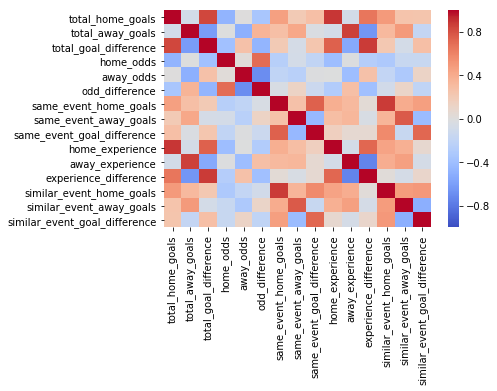

In [27]:
# Explore correlations
# Create a heatmap for a visual representation
# Highly correlated inputs may deflate the performance of the classifier
# As it is seen from the heat map, our features, even though some are,
# are not heavily correlated. However, during the feature engineering phase,
# we have generated features as subtraction of previous 2, which resuls in a 
# highly correlated feature. In other words, these can be thought as, increasing
# the 'importance' of the feature that is highly correlated with other features.
# Depending on the objective and model, this may or may not be a good strategy.
# For example; total_home_goals, total_away_goals, and total_goal_difference which is 
# (total_home_goals-total_away_goals) result in a high positive and negative correlations
# with each others, which can also be thought of as reinforcing the importance of these features
# towards decision making.
# PCA is used in the future stages to decorrelate the feature set

sns.heatmap(features.corr(), cmap='coolwarm', vmin=-1, vmax=1)

In [28]:
# Explore skewness
# Large deviations from 0, implies less of a normal distribution
# Normal distribution is usually assumed when working with PCA and classifiers
# Therefore, standardization will be used in the upcoming stages
features.skew()

total_home_goals                 0.212108
total_away_goals                 0.254789
total_goal_difference            0.065092
home_odds                        0.844708
away_odds                        0.866911
odd_difference                  -0.031029
same_event_home_goals            1.207241
same_event_away_goals            1.104181
same_event_goal_difference       0.463729
home_experience                 -0.287733
away_experience                 -0.298727
experience_difference            0.028240
similar_event_home_goals         0.946411
similar_event_away_goals         0.960642
similar_event_goal_difference    0.002715
dtype: float64

In [29]:
# Explore kurtosis
# Same applies here as well
features.kurtosis()

total_home_goals                -1.350885
total_away_goals                -1.173463
total_goal_difference           -0.768827
home_odds                       -0.666922
away_odds                       -0.618563
odd_difference                  -0.229784
same_event_home_goals            1.563550
same_event_away_goals            1.453195
same_event_goal_difference       1.190022
home_experience                 -1.259107
away_experience                 -1.278707
experience_difference           -0.607925
similar_event_home_goals         0.825371
similar_event_away_goals         0.989661
similar_event_goal_difference   -0.220820
dtype: float64

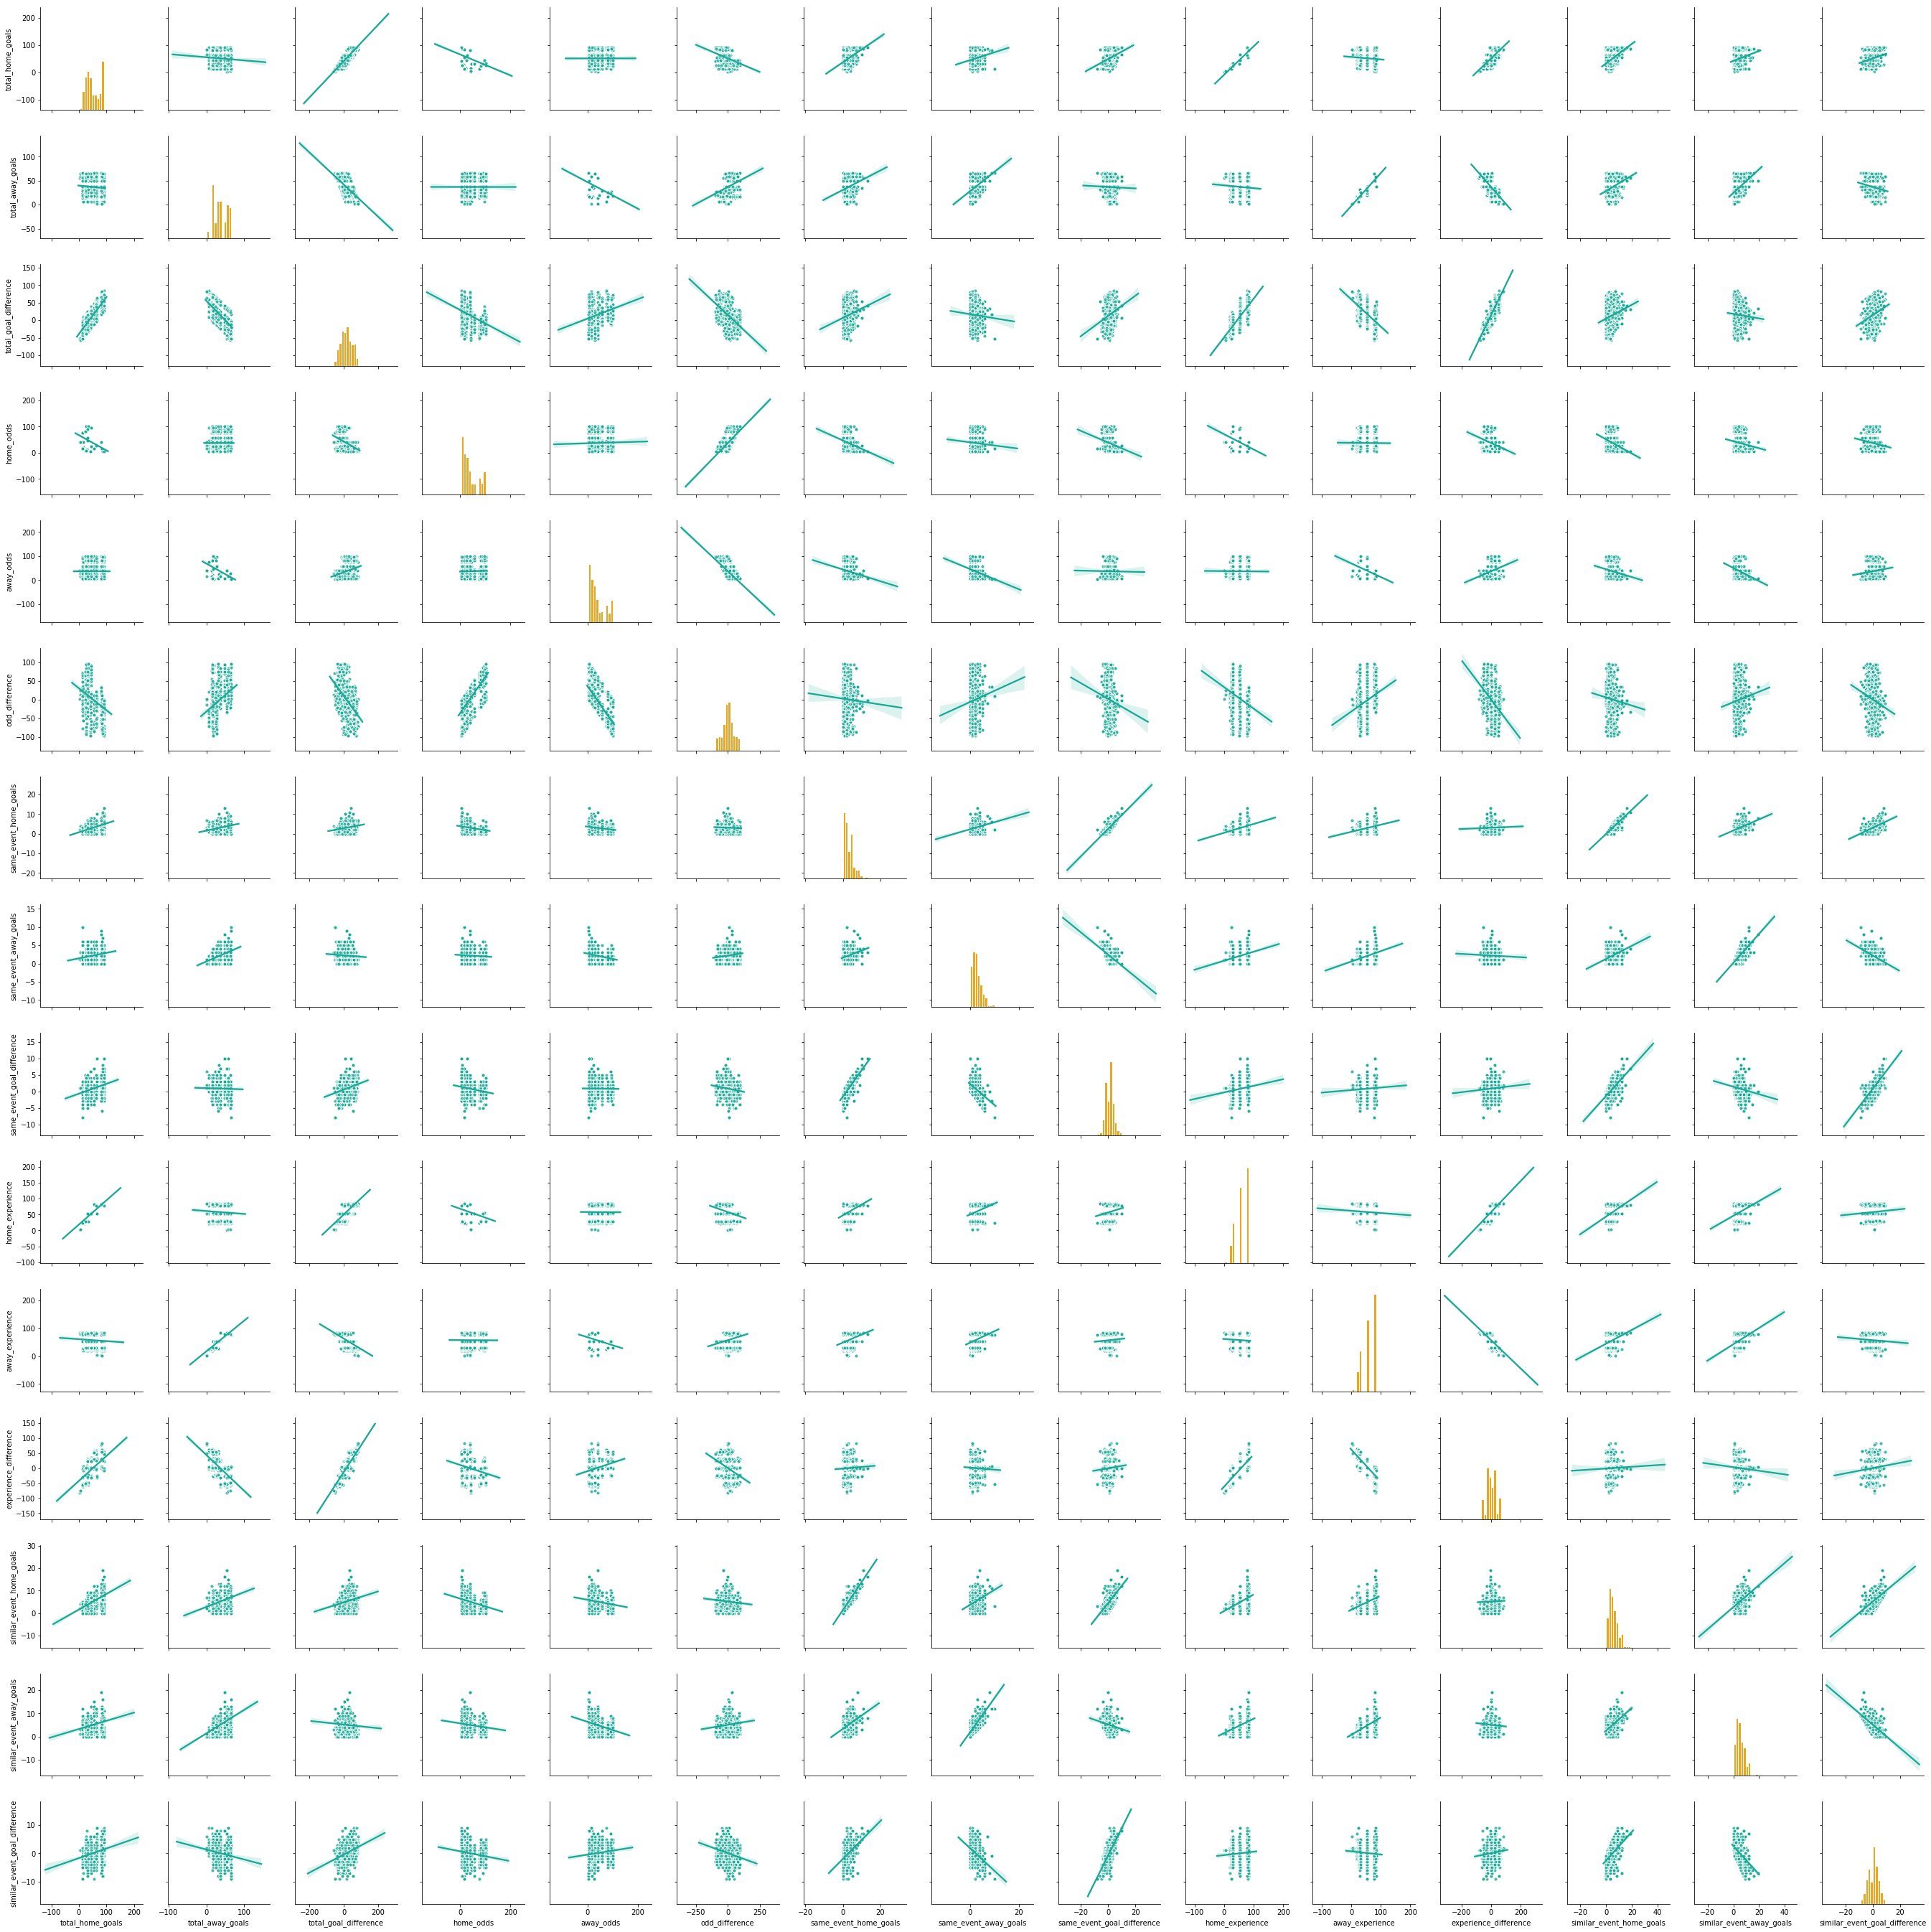

In [30]:
# Create Focused Pairwise RegPlot graph
# This cell may take 1-2 minutes
# One can visually observe the nature of the features here
# Some highly correlated, skewed features exist
g = sns.PairGrid(features, vars=feature_cols)
g.map_offdiag(sns.regplot, color="#19a897", scatter_kws={'s':25, 'edgecolor':"white", 'lw':1})
g.map_diag(plt.hist, color="#e8a622", edgecolor="white")

Transformations

In [31]:
# Not part of the pipeline at this moment
# For now, we are just analyzing the effects

# Apply the StandardScaler and PCA on the features dataset 
# in order to analyze the effect of transformations
# and observe the nature of data to be fed into the models to be built

# Standard scaler is utilized to prepare the feature set for PCA.
# PCA model in scikit-learn uses covariace matrix, which does the de-meaning,
# however, it deos not normalize the data, hence, leading to uneven weights 
# between different features. To avoid this behaviour, data is standard scaled beforehand,
# which also does de-meaning plus the normalization i.e. 0 mean, unit variance
# Later on, PCA decomposes the feature set into 'n' combinations of independent, uncorrelated
# components. By now, we are good to feed our models with the transformed feature set.

std_scaler_test = StandardScaler()
pca_test = PCA()
scaled_features = std_scaler_test.fit_transform(features)
covar_matrix = pca_test.fit(scaled_features)
scaled_pca_features = covar_matrix.transform(scaled_features)
feature_columns_test = ["feature_{0}".format(i) for i in range(1, scaled_pca_features.shape[1]+1)]
scaled_pca_features = pd.DataFrame(columns=feature_columns_test, data=scaled_pca_features)

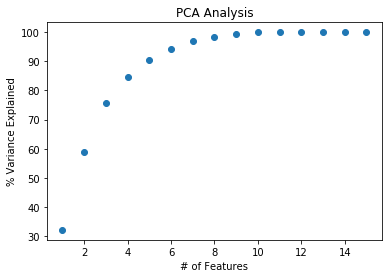

In [32]:
# Guessing the number of effective features (PCA explained variance ratios)
# PCA lets us to choose number of the componens that explains most of the overall variance in the dataset.
# From the plot below, one can conclude that 10 components out of 15 explain the ~99% of the total variance
# in the featrues data. 
variance = covar_matrix.explained_variance_ratio_
var=np.cumsum(np.round(variance, 3)*100.0)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.style.context('seaborn-whitegrid')
plt.scatter(range(1, len(var)+1), var)

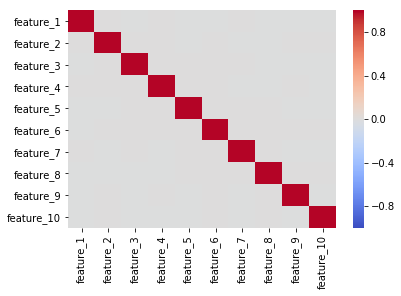

In [33]:
# Explore correlations after PCA
# Create a heatmap for a visual representation
# After applying standard scaler and PCA, we got uncorrelated, 
# independent componenets as promised that reasonably explain the dataset
sns.heatmap(scaled_pca_features[feature_columns_test[0:10]].corr(), cmap='coolwarm', vmin=-1, vmax=1)

In [34]:
# Explore skewness after PCA
# Noticeable reduction in the skewness
scaled_pca_features[feature_columns_test[0:10]].skew()

feature_1    -0.032242
feature_2     0.516793
feature_3     0.127725
feature_4     0.059341
feature_5     0.158974
feature_6     0.563375
feature_7     0.113256
feature_8     0.582051
feature_9     0.457394
feature_10    0.153715
dtype: float64

In [35]:
# Explore kurtosis
# Noticeable reduction in the kurtosis
scaled_pca_features[feature_columns_test[0:10]].kurtosis()

feature_1    -0.851286
feature_2    -0.429835
feature_3    -0.080670
feature_4    -0.331532
feature_5     0.112062
feature_6     0.222576
feature_7     0.696290
feature_8     0.265633
feature_9     0.070591
feature_10    0.554158
dtype: float64

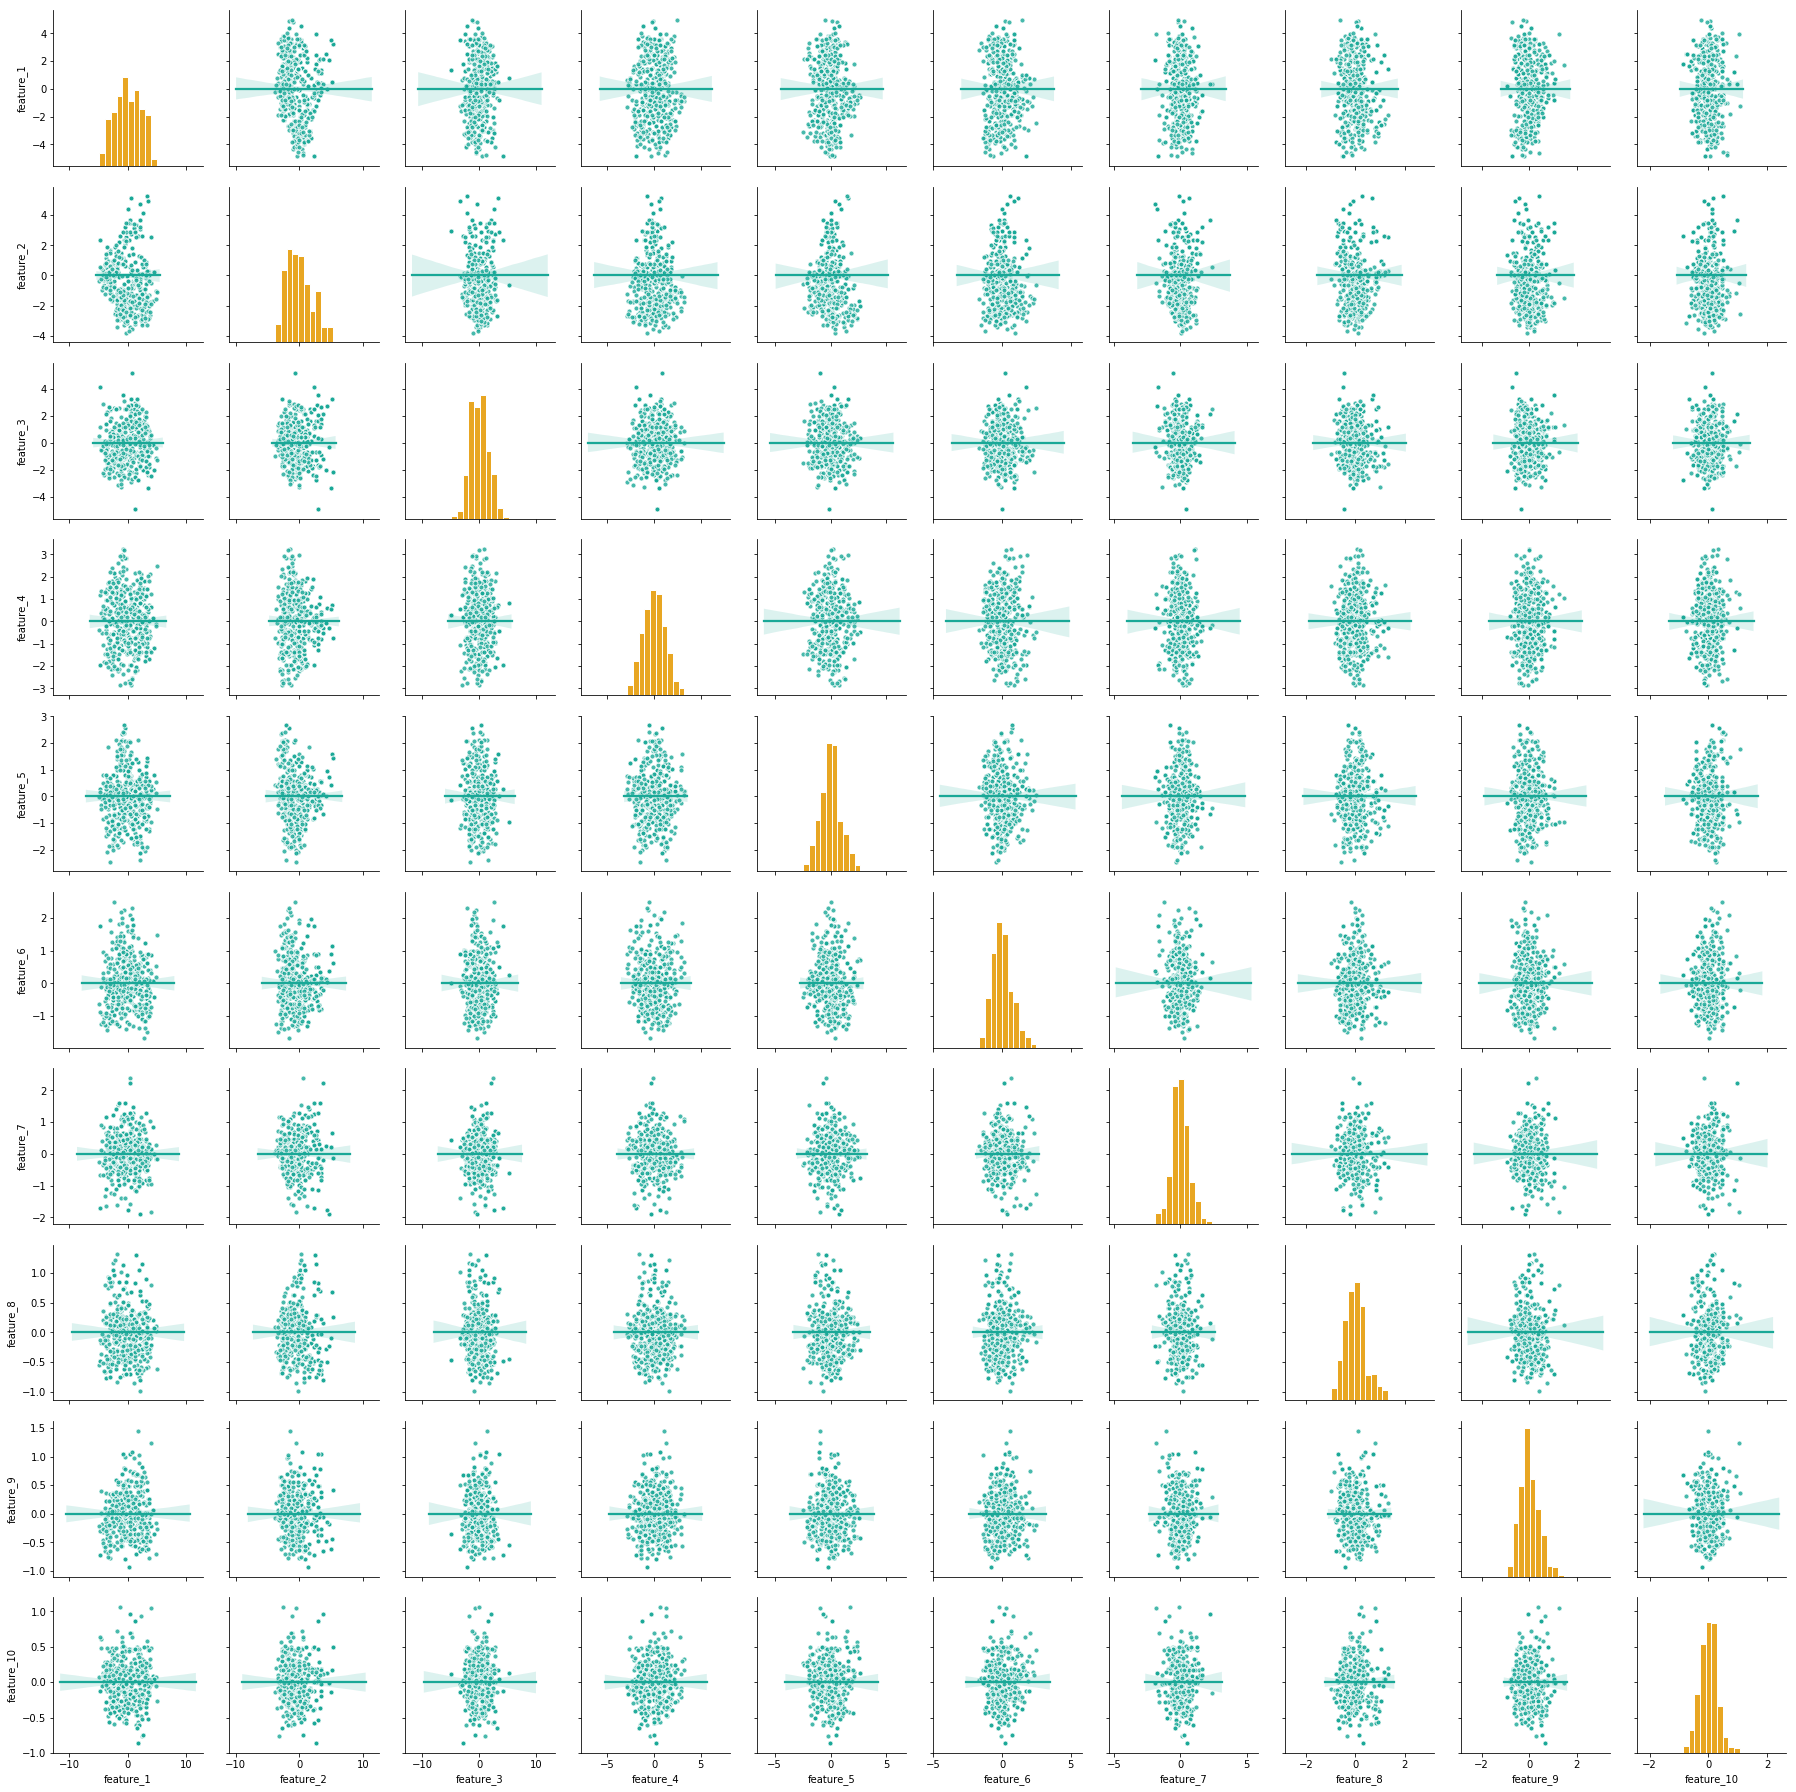

In [36]:
# Create focused pairwise RegPlot graph after PCA
# As it is seen from the plot below, features are scaled and follow the normal distribution 
g = sns.PairGrid(scaled_pca_features[feature_columns_test[0:10]], vars=feature_columns_test[0:10])
g.map_offdiag(sns.regplot, color="#19a897", scatter_kws={'s':25, 'edgecolor':"white", 'lw':1})
g.map_diag(plt.hist, color="#e8a622", edgecolor="white")

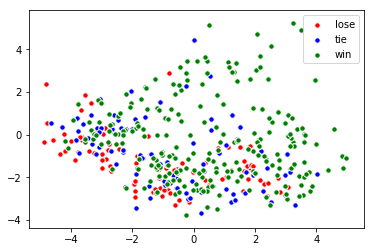

In [37]:
# features - label mapping after PCA (using 2 features for the ease of visualization)
# first 2 features are those that contribute the most to the dataset and therefore,
# we wanted to map them to the labels to see the nature of the problem at hand, either linearly
# seperable or not, how complex the model should be, and what to expect in terms of accuracy

# From the chart below, it can be observed that, win cases are relatively easier to classify 
# rather than the lose and tie cases, which constitute less of the dataset, and harder to distinguish.
# This would definitely have negative effect on the prediction accuracy, such that more tie, lose cases 
# will be misclassified.

# Therefore, we expect that a classifier with model complexity enough to handle the non-linear borders
# would perform better, such as Multi-layer Perceptron(a Neural Network).
scatter_x = scaled_pca_features['feature_1'].values
scatter_y = scaled_pca_features['feature_2'].values
group = label.values
cdict = {"win": 'green', "lose": 'red', "tie": 'blue'}

fig, ax = plt.subplots()
for g in np.unique(group):
    ix = np.where(group == g)
    ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 30, edgecolor='white')
ax.legend()
plt.show()

Pipelines

In [38]:
# Split into train/validation/test sets
# Please remember that the predict set is seperate and consists of 10 datapoints

# X_train_validation: 75% of the features
# X_test: 25% of the features
X_train_validation, X_test, y_train_validation, y_test = train_test_split(
    features, label, test_size=0.25, random_state=0, shuffle=True)

In [39]:
# General pattern is building the components of the pipeline,
# and tuning the model with the grid search
# Train_validation set is divided into 5 crossValidation sets: cv=5

# pipeline_1 (Multinomial Logistic Regression classifier)
std_scaler = StandardScaler()
pca = PCA()

# scorer is chosen as an accuracy scorer because of its simplicity and intuitionality
# after the best model is chosen, one may utilize more complex scorers e.g. f1_score, confusion_matrix
# to investigate and tune the model even further
scorer = make_scorer(accuracy_score)

LR = LogisticRegression(
    class_weight='balanced',
    random_state=0,
    solver='saga',
    max_iter=200)

estimators_LR = [('scaler', std_scaler), ('reducer', pca), ('clf', LR)]
parameters_LR = {'reducer__n_components': [8, 10, 12],
                 'clf__C': np.logspace(-5, 3, 5),
                 'clf__multi_class': ['multinomial', 'ovr']}

pipeline_LR = Pipeline(estimators_LR)

grid_LR = GridSearchCV(
    pipeline_LR,
    param_grid=parameters_LR,
    scoring=scorer,
    cv=5,
    n_jobs=None,
    return_train_score=False,
    iid=False)

In [40]:
# pipeline_2 (Multi-layer Perceptron classifier)
std_scaler = StandardScaler()
pca = PCA()
scorer = make_scorer(accuracy_score)

MLP = MLPClassifier(
    solver='adam',
    random_state=0)

estimators_MLP = [('scaler', std_scaler), ('reducer', pca), ('clf', MLP)]
parameters_MLP = {'reducer__n_components': [8, 10, 12],
                'clf__activation': ['logistic', 'tanh', 'relu'],
                'clf__alpha': np.logspace(-5, 3, 5),
                'clf__hidden_layer_sizes': [(5,),(9,),(13,)]}

pipeline_MLP = Pipeline(estimators_MLP)

grid_MLP = GridSearchCV(
    pipeline_MLP,
    param_grid=parameters_MLP,
    scoring=scorer,
    cv=5,
    n_jobs=None,
    return_train_score=False,
    iid=False)

In [41]:
# pipeline_3 (RandomForest classifier)
std_scaler = StandardScaler()
pca = PCA()
scorer = make_scorer(accuracy_score)

RF = RandomForestClassifier(
    max_features=None,
    random_state=0,
    class_weight='balanced')

estimators_RF = [('scaler', std_scaler), ('reducer', pca), ('clf', RF)]
parameters_RF = {'reducer__n_components': [8, 10, 12],
                 'clf__n_estimators': [10, 100]}

pipeline_RF = Pipeline(estimators_RF)

grid_RF = GridSearchCV(
    pipeline_RF,
    param_grid=parameters_RF,
    scoring=scorer,
    cv=5,
    n_jobs=None,
    return_train_score=False,
    iid=False)

In [42]:
# pipeline_4 (KNeighbors classifier)
std_scaler = StandardScaler()
pca = PCA()
scorer = make_scorer(accuracy_score)

KN = KNeighborsClassifier(
    algorithm='auto')

estimators_KN = [('scaler', std_scaler), ('reducer', pca), ('clf', KN)]
parameters_KN = {'reducer__n_components': [8, 10, 12],
                 'clf__n_neighbors': [3, 5, 10, 50]}

pipeline_KN = Pipeline(estimators_KN)

grid_KN = GridSearchCV(
    pipeline_KN,
    param_grid=parameters_KN,
    scoring=scorer,
    cv=5,
    n_jobs=None,
    return_train_score=False,
    iid=False)

In [43]:
# pipeline_5 (GaussianNB classifier)
std_scaler = StandardScaler()
pca = PCA()
scorer = make_scorer(accuracy_score)

GB = GaussianNB()

estimators_GB = [('scaler', std_scaler), ('reducer', pca), ('clf', GB)]
parameters_GB = {'reducer__n_components': [8, 10, 12]}

pipeline_GB = Pipeline(estimators_GB)

grid_GB = GridSearchCV(
    pipeline_GB,
    param_grid=parameters_GB,
    scoring=scorer,
    cv=5,
    n_jobs=None,
    return_train_score=False,
    iid=False)

In [44]:
# pipeline_6 (Support Vector classifier)
std_scaler = StandardScaler()
pca = PCA()
scorer = make_scorer(accuracy_score)

SVM = SVC(
    class_weight='balanced',
    probability=True,
    random_state=0
    )

estimators_SVM = [('scaler', std_scaler), ('reducer', pca), ('clf', SVM)]
parameters_SVM = {'reducer__n_components': [8, 10, 12]}

pipeline_SVM = Pipeline(estimators_SVM)

grid_SVM = GridSearchCV(
    pipeline_SVM,
    param_grid=parameters_SVM,
    scoring=scorer,
    cv=5,
    n_jobs=None,
    return_train_score=False,
    iid=False)

In [45]:
# Register grids
grids = list()
grids.append(("LogisticRegression", grid_LR))
grids.append(("MLPClassifier", grid_MLP))
grids.append(("RandomForest", grid_RF))
grids.append(("KNeighborsClassifier", grid_KN))
grids.append(("GaussianNB", grid_GB))
grids.append(("SVC", grid_SVM))

In [46]:
# Run the models
best_train_cv_scores = list()
test_scores = list()

for grid_name, grid in grids:
    print "Traning/CrossValidating: {0} ...".format(grid_name)
    tic = time.time()
    grid.fit(X_train_validation, y_train_validation)
    toc = time.time()
    print "Time spent in Traning/CrossValidating: {0} seconds".format(np.round(toc-tic, 2))
    y_pred = grid.predict(X_test)
    grid_best_tcv_score = grid.best_score_
    best_train_cv_scores.append(grid_best_tcv_score)
    print "Best Traning/CrossValidating accuracy score: {0} %".format(np.round(grid_best_tcv_score*100.0, 2))
    test_score = accuracy_score(y_test, y_pred)
    test_scores.append(test_score)
    print "Best Testing accuracy score: {0} %".format(np.round(test_score*100.0, 2))
    print "\n"


Traning/CrossValidating: LogisticRegression ...
Time spent in Traning/CrossValidating: 2.24 seconds
Best Traning/CrossValidating accuracy score: 72.9 %
Best Testing accuracy score: 65.97 %


Traning/CrossValidating: MLPClassifier ...
Time spent in Traning/CrossValidating: 98.08 seconds
Best Traning/CrossValidating accuracy score: 73.58 %
Best Testing accuracy score: 70.83 %


Traning/CrossValidating: RandomForest ...
Time spent in Traning/CrossValidating: 5.48 seconds
Best Traning/CrossValidating accuracy score: 63.87 %
Best Testing accuracy score: 56.25 %


Traning/CrossValidating: KNeighborsClassifier ...
Time spent in Traning/CrossValidating: 0.41 seconds
Best Traning/CrossValidating accuracy score: 64.59 %
Best Testing accuracy score: 61.11 %


Traning/CrossValidating: GaussianNB ...
Time spent in Traning/CrossValidating: 0.09 seconds
Best Traning/CrossValidating accuracy score: 68.04 %
Best Testing accuracy score: 61.81 %


Traning/CrossValidating: SVC ...
Time spent in Traning/Cr

Model Comparison based on the Train/CV scores


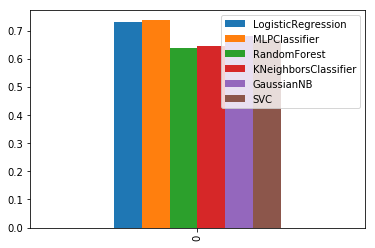

In [47]:
# Explore train/CV scores of all models
print "Model Comparison based on the Train/CV scores"
model_cols = [obj[0] for obj in grids]
train_cv_model_comparison = pd.DataFrame(columns=model_cols, data=np.array([best_train_cv_scores]))
train_cv_model_comparison.plot.bar()

Model Comparison based on the Test scores


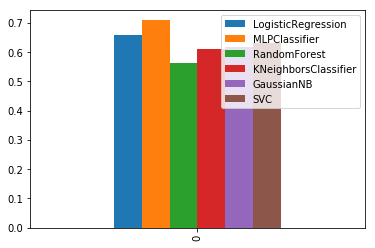

In [48]:
# Explore test scores of all models
print "Model Comparison based on the Test scores"
model_cols = [obj[0] for obj in grids]
test_model_comparison = pd.DataFrame(columns=model_cols, data=np.array([test_scores]))
test_model_comparison.plot.bar()

In [49]:
# Find best model
# Find the best model based on the test accuracy score
best_test_score = -1.0
best_index = -1
for index, score in enumerate(test_scores):
    if score > best_test_score:
        best_test_score = score
        best_index = index

best_model = grids[best_index]
print "Best model is: {0}\nBest test accuracy score is: {1} %".format(
    best_model[0], np.round(best_test_score*100.0, 2))
print "Historic accuracy score was: {0} %".format(historic_accuracy)

Best model is: MLPClassifier
Best test accuracy score is: 70.83 %
Historic accuracy score was: 51.74 %


Normalized confusion matrix
[[0.87142857 0.08571429 0.04285714]
 [0.48148148 0.18518519 0.33333333]
 [0.10638298 0.12765957 0.76595745]]


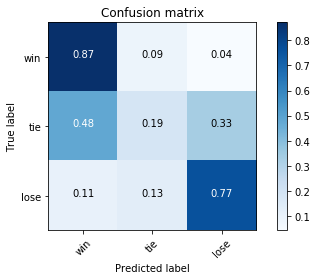

In [50]:
# Compute and plot the confusion matrix
y_pred = best_model[1].predict(X_test)
class_names = ['win', 'tie', 'lose']
cnf_matrix = confusion_matrix(y_test, y_pred, labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Confusion matrix')
plt.show()

In [51]:
# Predict the 'predict set'
probabilities = best_model[1].predict_proba(predict_features)
temp = pd.DataFrame(columns=['lose', 'tie', 'win'], data=probabilities)[['win', 'tie', 'lose']]
predict[['closing_implied_prob_1', 'closing_implied_prob_X', 'closing_implied_prob_2']] = temp.values
predict[['event_name', 'closing_implied_prob_1', 'closing_implied_prob_X', 'closing_implied_prob_2']]

,event_name,closing_implied_prob_1,closing_implied_prob_X,closing_implied_prob_2
576,Husqvarna FF - Grebbestads IF,0.372603,0.363512,0.263885
577,Eskilsminne IF - Mjällby AIF,0.309810,0.413615,0.276576
578,Ljungskile SK - Skövde AIK,0.425392,0.489434,0.085174
579,Torns IF - FK Karlskrona,0.422965,0.394872,0.182163
580,Kristianstads FF - Åtvidabergs FF,0.414136,0.234339,0.351524
581,Ängelholms FF - Tvååkers IF,0.338853,0.479632,0.181516
582,Utsiktens BK - Lunds BK,0.377745,0.396384,0.225871
583,IK Oddevold - Oskarshamns AIK,0.582390,0.286756,0.130853


In [52]:
conn.close()

Discussion

Up until here, we have already discussed the way data is preprocessed, transformed, and fed into the models.
Model building was straightforward. Grid search helped us to tune the models and get the best out of them.
Accuracy score come handy to compare the model accuracy of the test data and choose the best model for our final prediction of the unseen predict dataset. Overall, we concluded that MLPClassifier outperformed other models with the test accuracy of ~ 71%. These figures are for the Swedish league dataset, but the analysis of the models can be translated onto the Colombian dataset as well. MLPClassifier is the winner there as well.

First of all, I would like to mention that the inherent nature of the football match dataset makes it challenging to achive high accuracy scores due to its stochasticity. Furthermore, so as to achive the high accuracy scores, it would be important to integrate more supportive datasets that describe the players of the team, if there are injuries, weather conditions and etc. The historic accuracy score of ~52% portrays the scenario that in the absence of more independenet and descriptive features, models are doomed to underperform.

Furthermore, amount of data available is another factor that affects the accuracy. Indeed, testing the models with less training data led to slight decrease in the accuracy score. As the size of the dataset increases, the probability of similar patterns occuring repeatedly increases as well, and the chance of the test dataset containing unseen 'surprises' decreases. This way, model gets the opportunity to update itself with respect to the repeating patterns, hence performing better.

In addition to these, pertaining to the classification problems, there is another factor to take into account. This is the frequency of the labels appearing in the dataset. If we have unbalanced dataset, such that number of win cases is significantly larger than the others, then it is expected that model will make errors for the lose and tie cases. To avoid this, we have tuned our models to use balanced class weight. However, we still observe that win cases have dominated the predictions and deflated the model accuracy. This phenomenon is better seen by interpreting the confusion matrix.

The confusion matrix is another way of assessing the model performance. Even though, accuracy score is used to select the best model, we still need to look into the confusion matrix, to see in which parts, our model could have gone wrong. The confusion matrix shows us that, out best model showed worst true positive performance while making the 'tie' predictions, which is an interesting case. I would speculate that the reason for this is the following.

Most of the features we have engineered, relies on the cumulative scores by the teams e.g. total goals by the teams, experiences, odds and etc. Even if a tie occurs for a match, most of the time, (cumulative) features we have designed, differed noticeably for the home team and the away team, which is also true for the win and lose cases. Therefore, model struggled to derive a definitive pattern for a game being a 'tie', and due to the ratio of 'tie' cases to 'win'+'lose' cases being low, model predicted win or lose for a tie game.

I would like to end this discussion by wrapping up some of the already proposed areas for improvement.
Having access to larger, more balanced, more descriptive dataset, careful feature engineering and adding custom weights for features if needed, experimenting with deep neural networks would result in a more desirable outcome.